In [2]:
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
include("/home/jm2386/Active_Lattice/src/pm_pdes.jl");
include("/home/jm2386/Active_Lattice/src/pm_sims.jl");
include("/home/jm2386/Active_Lattice/src/pm_plot.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");


v3.0
v4.0


In [3]:
## outer 6 
function ff_out_7(F,u,p; atol = 1e-12)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = p
        global ρ,ρa,m,ep
        local c
        ρ  = u[(0*Nx+1):1:(1*Nx)]
        ρa = u[(1*Nx+1):1:(2*Nx)]
        c  = u[end]

        for i in 2:(ind-1)
            F[i-1]      = rho_out_eq_2(ρ,ρa,c,i; p = p) - rho_out_eq_2(ρ,ρa,c,1; p = p)
            F[Nx-3+i]   = act_out_eq_2(ρ,ρa,c,i; p = p) - act_out_eq_2(ρ,ρa,c,1; p = p)
        end

        for i in (ind+1):1:(Nx-1)
            F[i-1]      = rho_out_eq_2(ρ,ρa,c,i; p = p) - rho_out_eq_2(ρ,ρa,c,1; p = p)
            F[Nx-3+i]   = act_out_eq_2(ρ,ρa,c,i; p = p) - act_out_eq_2(ρ,ρa,c,1; p = p)
        end

        ind1 = 1
        γ_end = (-ρa[end].+1)./(-ρ[end].+1)
        γ_srt = (-ρa[ind1].+1)./(-ρ[ind1].+1)
        F[ind-1]    = gg0.(ρ[end], γ_end; Pe = v0) - gg0.(ρ[ind1], γ_srt; Pe = v0)
        F[Nx-3+ind] = (hhh0.(ρ[end], γ_end; Pe = v0, atol = atol) - hhh0.(ρ[ind1], γ_srt; Pe = v0, atol = atol))./10
        F[2*Nx+1]   = γ_end .- γ_srt

        ind1 = ind +1 
        F[2*Nx-3] = ρa[ind] - ϕaL
        F[2*Nx-2] = ρa[ind1] - ϕaR
        F[2*Nx-1] = ρ[ind] - ϕL
        F[2*Nx]   = ρ[ind1] - ϕR 
end

function load_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    param, ps = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    filename = outer_save_name_7(param,ind,γ)
    data = load(filename)
    @unpack f, c = data
    u = get_out_u(f,c,Lx)
    return f, u, c
end

using NonlinearSolve, DifferentialEquations
function solve_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ,u0; tol = 1e-8, maxiters = 100)
    param, p = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    # Set problem
    prob = NonlinearProblem(ff_out_7,u0, p; abstol = tol, reltol =  tol, maxiters = maxiters);
    sol  = solve(prob)
    #
    # Save
        u = sol.u
        f = get_out_f(u,param)
        c = u[end]/Lx
        filename    = outer_save_name_7(param,ind,γ)
        data        = Dict("f" => f, "c" => c)
        safesave(filename,data)
    #
    return f, u, c
end

function get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    param = get_stretch_param(Lx)
    name = "outer_sol_7"
    Δx = Lx/Nx
    DT = DR = 1.0
    ϕaL, ϕaR, ϕL, ϕR = get_BC(γ,v0;initial_Δ = 1e-6, tol = 1e-8 )
    @pack! param = Lx,Nx,ϕa,ϕp,v0,name,Δx
    ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR
    return param, ps
end

function outer_save_name_7(param,ind,γ)
    @unpack DT, v0, DR, Nx, Lx, name, ϕa, ϕp = param
    return "/store/DAMTP/jm2386/Active_Lattice/data/pm_pdes_pro/outer_sol/$(name)/[DT,v0,DR,Nx,ind,γ]=$([DT,v0,DR,Nx,ind,γ]).jld2"
end

function check_u_7(u,ps)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    param, _ = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    F = zeros(2*Nx+1)
    ff_out_7(F,u,ps)
    f = get_out_f(u,param)
    avmag = Lx*sum(f[:,2]-f[:,1])/Nx
    return maximum(abs.(F)), argmax(abs.(F)), avmag, u[end]/Lx
end

function increase_ind_7(u,ps)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    i = ind
    u[i+1] = u[i]
    i = Nx + i 
    u[i+1] = u[i]
    ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, (ind+1), γ, ϕaL, ϕaR, ϕL, ϕR
    return u, ps
end

function decrease_ind_7(u,ps)
    DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    i = ind
    u[i] = u[i+1]
    i = Nx + i
    u[i] = u[i+1]
    ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, (ind-1), γ, ϕaL, ϕaR, ϕL, ϕR
    return u, ps
end

function increase_inds(u,ps,n)
    for i in 1:n
        u, ps = increase_ind_7(u,ps)
    end
    return u, ps
end

function decrease_inds(u,ps,n)
    for i in 1:n
        u, ps = decrease_ind_7(u,ps)
    end
    return u, ps
end
# 

decrease_inds (generic function with 1 method)

In [3]:
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 56, 2.03
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 800, 1.5
param, ps = get_outer_param_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
f,u,c = load_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ)
# f,u,c = solve_out_7(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters = 10)
# check densities
        ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
        ϕa = sum(f[:,1:2])/Nx
#
rhodiff = u[ind+1] - u[ind]
err, erri, avmag, cep = check_u_7(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): rhodiff=$(rhodiff), c =$(c), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")

ArgumentError: ArgumentError: No file exists at given path: /store/DAMTP/jm2386/Active_Lattice/data/pm_pdes_pro/outer_sol/outer_sol_7/[DT,v0,DR,Nx,ind,γ]=[1.0, 7.5, 1.0, 1024.0, 780.0, 1.5].jld2

In [54]:
ρ  = u[(0*Nx+1):1:(1*Nx)]
ρa  = u[(1*Nx+1):1:(2*Nx)]
γ_end = (-ρa[end].+1)./(-ρ[end].+1)

1.7369414724789993

In [7]:
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 1000, 1.4
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 56, 1.7369414724789993
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 208, 1.71
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 840, 1.5
Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 780, 1.48
param, ps = get_outer_param_6(Lx,Nx,ϕa,ϕp,v0,ind,γ)
# f,u,c = load_out_6(Lx,Nx,ϕa,ϕp,v0,ind,γ)
f,u,c = solve_out_6(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters =10)
# check densities
    ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
    ϕa = sum(f[:,1:2])/Nx
#
rhodiff = u[ind+1] - u[ind]
err, erri, avmag, cep = check_u_6(u,ps);
println("ϕa,ϕp=($(d4(ϕa)),$(d4(ϕp))): rhodiff=$(rhodiff), c =$(c), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")

ϕa,ϕp=(0.4884,0.2128): rhodiff=0.06587023064891262, c =0.003637303276697616, avmag=0.27092175583068756, err=1.4752215005131575e-9,778, ind=780


In [9]:
ϕa,ϕp

(0.48838812368458373, 0.21276827493984996)

In [26]:
Lx,Nx,ϕa,ϕp,v0 = 100.0, 3200, 0.45, 0.24, 7.5 # approx atm
# f,u,c = load_full(Lx,Nx,d2(ϕa),d2(ϕp),v0)
# f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8)
f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0)
# axs[6].plot(f[:,1]+f[:,2],f[:,3]; color = "black", linestyle = "--")

([0.37435102535342407 0.161956936390576 0.13721436269815046; 0.35499423593071 0.15846483983113302 0.14396907103075685; … ; 0.4127687202286834 0.17057238871246738 0.12333356280994323; 0.3937138926018835 0.16597667900504198 0.13030942839307447], [0.6735223244421505; 0.6574281467925999; … ; -0.22773721359684151; 0.008293203944808805;;], 0.008293203944808805)

In [18]:
Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.4923593417152868, 0.216, 7.5
# Lx,Nx,ϕa,ϕp,v0 = 100.0, 3200, 0.48, 0.22, 7.5 # approx atm
# Lx,Nx,ϕa,ϕp,v0 = 100.0, 3200, 0.42, 0.22, 7.5 # approx atm
# f,u,c = load_full(Lx,Nx,d2(ϕa),d2(ϕp),v0)
# f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8)
f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0)
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0)
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)")

ϕa,ϕp=(0.4923593417152868,0.216): cep =0.016752468554802474, err=9.379310522694695e-11,594


In [17]:
Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.4923593417152868, 0.2155, 7.5
f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 10)
# f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0)
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0)
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)")

InterruptException: InterruptException:

In [66]:
f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 20)
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0)
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)")

ϕa,ϕp=(0.4923593417152868,0.216): cep =0.0034850134654074876, err=0.014257005464046263,4


In [12]:
Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.4923593417152868, 0.2155, 7.5
f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");


f = f[2:2:end,:];
u = get_u(f,c);
Lx,Nx,ϕa,ϕp,v0 = 25.0, Nx÷2, 0.4923593417152868, 0.216, 7.5;
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

tol = 1e-8
maxiters = 20
prob = NonlinearProblem(ff,u, ps; abstol = tol, reltol =  tol, maxiters = maxiters);
sol  = solve(prob)
        

ϕa,ϕp=(0.4923593417152868,0.216): cep =0.019847568714858155, err=2.5381363677468016e-12,4402
ϕa,ϕp=(0.4923593417152868,0.216): cep =0.019847568714858155, err=0.0037208824349581893,2185


retcode: Success
u: 2401×1 Matrix{Float64}:
  0.6943399571926184
  0.6806697557567313
  0.6674791904221213
  0.654880483885038
  0.642964406768269
  0.6317986703370968
  0.6214278611866996
  0.6118746918835398
  0.6031422470576561
  0.5952168710629437
  ⋮
 -0.2637018345757718
 -0.2608777554814926
 -0.2559753118525872
 -0.24910004621606105
 -0.24041667695050772
 -0.23014143354293481
 -0.2185311892656337
 -0.20587025976636278
  0.016752468554802474

In [13]:
# Save
    u = sol.u
    f = get_f(u)
    c = u[end]
    filename    = save_name_full(param)
    data        = Dict("f" => f, "c" => c)
    safesave(filename,data)
#
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

ϕa,ϕp=(0.4923593417152868,0.216): cep =0.016752468554802474, err=9.379295257128106e-11,594


In [49]:
Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.4923593417152868, 0.216, 7.5;
f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)")

for Lx in 47.5:-12.5:25.0
    global Nx,ϕa,ϕp,v0
    Lx,Nx,ϕa,ϕp,v0 = Lx, Nx, 0.4923593417152868, 0.216, 7.5
    param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0)
    f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 5)
    err, erri, avmag, cep = check_u_full(u,ps);
    println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)")
end


([0.3462037682572854 0.17299683194658888 0.16242404518580256; 0.31389880737716713 0.1677643984138524 0.17517565533002755; … ; 0.41282130992646715 0.1887320290505915 0.13450144423293797; 0.3797842287493776 0.1798786241074138 0.1486964888584954], [0.6816246453896768; 0.6568388611210471; … ; -0.19990560464196386; 0.003485013465407486;;], 0.003485013465407486)

In [32]:
# for i in 1:7
    # global u, ps, f,c, DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR
    u,ps = increase_inds(u,ps,1)
    DT, v0, DR, Δx, Nx, Lx, ϕa,ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
    # γ = 1.8
    # ind = 701
    f,u,c = solve_out_6(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters = 20)
    # check densities
        ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
        ϕa = sum(f[:,1:2])/Nx
    #
    param, ps = get_outer_param_6(Lx,Nx,ϕa,ϕp,v0,ind,γ)
    err, erri, avmag, cep = check_u_6(u,ps);
    rhodiff = u[ind+1] - u[ind]
    println("ϕa,ϕp=($(d4(ϕa)),$(d4(ϕp))): rhodiff=$(rhodiff), cep =$(cep), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")
# end

ϕa,ϕp=(0.2519,0.1889): rhodiff=-1.4432899320127035e-15, cep =0.02124056431299977, avmag=0.3277575015173716, err=0.006929378305753797,1007, ind=1009


In [70]:
f

900×3 Matrix{Float64}:
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 ⋮                   
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341
 0.113327  0.113327  0.152341

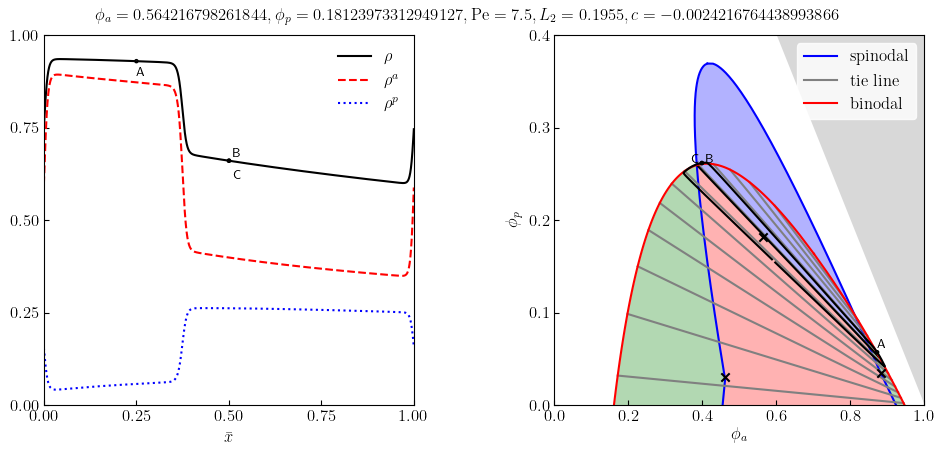

In [28]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
ind = 3*Nx÷4
show_f(axs,fig,12,param,f; c=c, point = ind-Nx÷2, Δϕ = 0.001)

In [46]:
# Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.4923593417152868, 0.2156, 7.5
# Lx,Nx,ϕa,ϕp,v0 = 25.0, 3200, 0.5,0.0, 7.5
# Lx,Nx,ϕa,ϕp,v0 = 50.0, 1600, 0.4923593417152868,0.2120026039537824, 7.5
# Lx,Nx,ϕa,ϕp,v0 = 50.0, 3200, 0.5628841851148594,0.19210167920225363, 7.5

Lx,Nx,ϕa,ϕp,v0 = 25.0, 3200, 0.5931, 0.18123973312949127, 7.5;
# Lx,Nx,ϕa,ϕp,v0 = 100.0, 6400, 0.564216798261844,0.18123973312949127, 7.5;

f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
# f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 5)
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

ArgumentError: ArgumentError: No file exists at given path: /store/DAMTP/jm2386/Active_Lattice/data/pm_pdes_pro/full_sol/sol_full/[DT,v0,DR,Lx,Nx,ϕa,ϕp]=[1.0, 7.5, 1.0, 25.0, 3200.0, 0.5931, 0.18123973312949127].jld2

In [23]:
m = f[:,2] - f[:,1]
ind1 = argmax(m)
ind2 = argmin(m)
rho = sum(f;dims=2)
rhoa = f[:,2] + f[:,1]
γs = (rhoa .-1)./(rho .-1)
γs[ind1], γs[ind2], 1024-1024*(ind2-ind1)÷Nx, sum(f)/Nx

(1.6221888926629613, 1.8160205985002056, 647, 0.7454565313913354)

In [45]:
# Lx,Nx,ϕa,ϕp,v0,ind,γ = 100.0, 1024, 0.3, 0.3, 7.5, 648, 1.62
param, ps = get_outer_param_6(Lx,Nx,ϕa,ϕp,v0,ind,γ)
f,u,c = load_out_6(Lx,Nx,ϕa,ϕp,v0,ind,γ)
# u, ps = increase_inds(u,ps,4)
# DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp, ind, γ, ϕaL, ϕaR, ϕL, ϕR = ps
# f,u,c = solve_out_6(Lx,Nx,ϕa,ϕp,v0,ind,γ,u; tol = 1e-8, maxiters =10)
# check densities
    ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
    ϕa = sum(f[:,1:2])/Nx
    ϕ = ϕa + ϕp
#
rhodiff = u[ind+1] - u[ind]
err, erri, avmag, cep = check_u_6(u,ps);
println("ϕa,ϕp=($(d4(ϕa)),$(d4(ϕp))): rhodiff=$(rhodiff), c =$(c), avmag=$(avmag), err=$(err),$(erri), ind=$(ind)")
ϕ

ϕa,ϕp=(0.5718,0.1888): rhodiff=0.15630067319125507, c =0.0020351487789256367, avmag=0.24184360910372316, err=3.973665840817375e-11,646, ind=648


0.7605612435891749

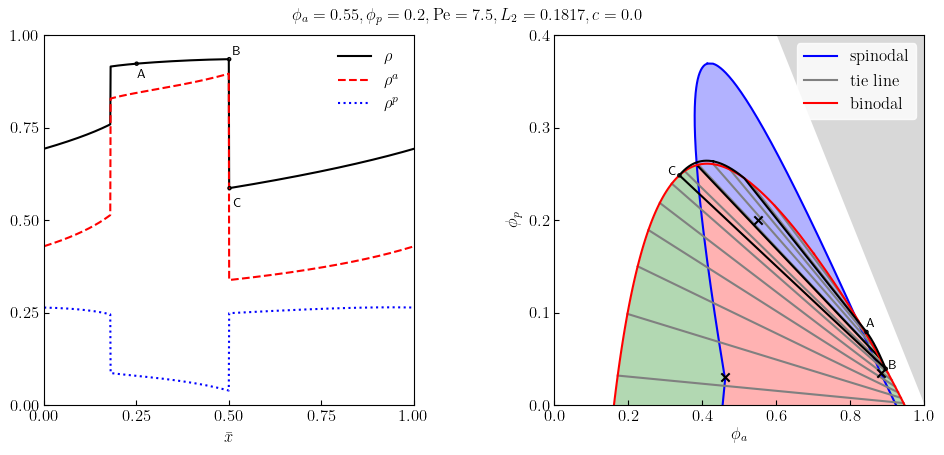

In [44]:
using PyPlot, LaTeXStrings
fig, axs = subplots(1,2,figsize=(10,5))
rc("text", usetex=true)
ind = 3*Nx÷4
show_f(axs,fig,12,param,f; c=c, point = ind-Nx÷2, Δϕ = 0.001)

In [29]:
argmax(sum(f;dims =2))
argmin(sum(f;dims =2))

CartesianIndex(36, 1)

In [ ]:
Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.4923593417152868, 0.21556, 7.5
f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

tol = 1e-8;
maxiters = 10;
prob = NonlinearProblem(ff,u, ps; abstol = tol, reltol =  tol, maxiters = maxiters);
sol  = solve(prob)

# Save
    u = sol.u;
    f = get_f(u);
    c = u[end];
    filename    = save_name_full(param);
    data        = Dict("f" => f, "c" => c);
    safesave(filename,data);
#

param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

In [21]:
Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.4923593417152868, 0.1, 7.5
ind = (Nx*840)÷1024
γ = (1-ϕa)/(1-ϕa-ϕp)
ϕaL, ϕaR, ϕL, ϕR = get_BC(γ ,v0)
ϕpL, ϕpR = ϕL-ϕaL, ϕR-ϕaR
f = vcat([ϕaL/2 ϕaL/2  ϕpL] .* ones(ind-Nx÷2), [ϕaR/2 ϕaR/2  ϕpR] .* ones(Nx-ind),[ϕaL/2 ϕaL/2  ϕpL] .* ones(Nx÷2))
c = 0.0
u = get_u(f,c)

param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");


ϕa,ϕp=(0.4923593417152868,0.1): cep =0.0, err=9.016746066295564,256


In [24]:
u = sol.u;
f = get_f(u);
c = u[end];
filename    = save_name_full(param);
data        = Dict("f" => f, "c" => c);
safesave(filename,data);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

ϕa,ϕp=(0.4923593417152868,0.1): cep =-0.021379490353588604, err=4.714453139648422,401


In [50]:
#compute bindoal
Pe = 7.5
Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.5628841851148594,0.19210167920225363, 7.5
# ind = (Nx*840)÷1024
γ = (1-ϕa)/(1-ϕa-ϕp)
# γ = 1.1

find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = (1-10e-16), initial_Δ = 1e-8, max_iter = 100, tol = 1e-14) 
ϕ1 = lower_limits[1]  
ϕ2 = upper_limits[2] 

#define problem
using DifferentialEquations

function fode(du,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    du[1] = Pe*(1-u[1])*u[2]
    du[2] = -Pe*u[2]^2 + Pe*( (1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1]) -(2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])
    return du
end

function f_jac(J,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    J[1,1] = -Pe*u[2]
    J[1,2] =  Pe*(1-u[1])
    J[2,1] =  self_diff_prime(u[1])*            (2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])^2              + (2/Pe)/(1-u[1])/self_diff(u[1])
    J[2,1] += self_diff_prime(u[1])*Pe*((1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1])^2  + Pe*(γ*self_diff(u[1]) +(1-γ*(1-u[1]))*self_diff_prime(u[1]) )/self_diff(u[1])
    J[2,2] = -2*Pe*u[2]
    return J
end

#compute solution 
parameters = (Pe, γ, ϕ1, ϕ2)
ffode = ODEFunction(fode;jac=f_jac)
ϵ = 1e-8
initial_position = [ϕ1+ϵ, 0.0]
time_interval = (0.0, 10.0)

ffode = ODEFunction(fode;jac=f_jac)
prob = ODEProblem(ffode,initial_position,time_interval, parameters)

sol = DifferentialEquations.solve(prob,abstol = 1e-12, reltol = 1e-12, maxiters =10000);

# #find central time
t_mid_arg = argmax(sol[2,:])
t_middle = sol.t[t_mid_arg]
t_max = maximum(sol.t[:].-t_middle)
t_min = minimum(sol.t[:].-t_middle)
arg_max = argmax(sol.t[:].-t_middle)
arg_min = argmin(sol.t[:].-t_middle)
t_lim = round(min(t_max, - t_min))
sol[1,t_mid_arg]

rho_strt = 1 #argmin(abs.(sol[1,:].-ϕ1.-0.05))
rho_end  = arg_max # argmin(abs.(sol[1,:].-ϕ2.+0.05))
drho = (sol[1,(rho_strt+1):(rho_end)].-sol[1,(rho_strt):(rho_end-1)])./(sol.t[(rho_strt+1):(rho_end)].-sol.t[(rho_strt):(rho_end-1)]);
infec_pt = argmax(drho)

74

In [51]:
ϕaL, ϕaR, ϕL, ϕR = get_BC(γ ,Pe)
ϕpL, ϕpR = ϕL-ϕaL, ϕR-ϕaR

(0.26081930850873725, 0.0562244197048396)

In [65]:
interface_size = 400
t_radius = 5.0
interface_ts = collect(-t_radius:(2*t_radius/(interface_size-1)):t_radius) .+ sol.t[infec_pt];
l_int_rho = hcat(sol.(interface_ts)...)[1,:];
l_int_mag = hcat(sol.(interface_ts)...)[2,:];
r_int_rho = l_int_rho[end:-1:1];
r_int_mag = - l_int_mag[end:-1:1];

l_int_rhoa = (l_int_rho.-1)*γ .+ 1
r_int_rhoa = (r_int_rho.-1)*γ .+ 1
l_int_rhop = l_int_rho-l_int_rhoa
r_int_rhop = r_int_rho-r_int_rhoa

l_int_ar = (l_int_rhoa+ l_int_mag)/2
l_int_al = (l_int_rhoa- l_int_mag)/2
r_int_ar = (r_int_rhoa+ r_int_mag)/2
r_int_al = (r_int_rhoa- r_int_mag)/2

Lx,Nx,ϕa,ϕp,v0 = 100.0, 3200, 0.5628841851148594,0.19210167920225363, 7.5
ind = 1060

f = vcat([ϕaL/2 ϕaL/2  ϕpL] .* ones(ind-interface_size÷2), hcat(l_int_al,l_int_ar,l_int_rhop)  , [ϕaR/2 ϕaR/2  ϕpR] .* ones(Nx-interface_size-2*ind), hcat(r_int_al,r_int_ar,r_int_rhop), [ϕaL/2 ϕaL/2  ϕpL] .* ones(ind-interface_size÷2))
f = circshift(f,(-ind,0))
c = 0.0
u = get_u(f,c)

ϕp = sum(f)/Nx-sum(f[:,1:2])/Nx
ϕa = sum(f[:,1:2])/Nx

param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");


ϕa,ϕp=(0.5632274141856611,0.19195083844425154): cep =0.0, err=0.09260771874493345,1080


In [71]:
Lx,Nx,ϕa,ϕp,v0 = 100.0, 3200, 0.5628841851148594,0.19210167920225363, 7.5
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

ϕa,ϕp=(0.5628841851148594,0.19210167920225363): cep =-0.0010467991074768856, err=0.015460073241548161,9574


In [67]:
tol = 1e-8;
maxiters = 2;
prob = NonlinearProblem(ff,u, ps; abstol = tol, reltol =  tol, maxiters = maxiters);
sol  = solve(prob)

retcode: MaxIters
u: 9601×1 Matrix{Float64}:
  0.7644362569688701
  0.7739702719155843
  0.7835093589547522
  0.7929761762821174
  0.8022969855529076
  0.8114038215891074
  0.8202362011032873
  0.8287424618414239
  0.836880468423298
  0.8446179714229053
  ⋮
  0.09130749640751849
  0.10059623379488539
  0.1103006733232606
  0.12031836177502864
  0.1305248609617937
  0.14077560817662924
  0.15090945748461299
  0.16075314066215027
 -0.0010467991074768856

In [70]:
u = sol.u 
f = get_f(u)
c = u[end]

param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

ϕa,ϕp=(0.4923593417152868,0.2120026039537824): cep =-0.0010467991074768856, err=73.76921238301026,4797


In [47]:
u = sol.u;
f = get_f(u);
c = u[end];
filename    = save_name_full(param);
data        = Dict("f" => f, "c" => c);
safesave(filename,data);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

ϕa,ϕp=(0.5628162750731772,0.1921315239998972): cep =-0.004299304402879612, err=0.01011449337750138,3749


In [77]:
Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.5628841851148594,0.19210167920225363, 7.5
f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);

# Lx,Nx,ϕa,ϕp,v0 = 50.0, 1600, 0.5628841851148594,0.19210167920225363, 7.5
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

# f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 5)
# param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0)
# err, erri, avmag, cep = check_u_full(u,ps);
# println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)")

ArgumentError: ArgumentError: No file exists at given path: /store/DAMTP/jm2386/Active_Lattice/data/pm_pdes_pro/full_sol/sol_full/[DT,v0,DR,Lx,Nx,ϕa,ϕp]=[1.0, 7.5, 1.0, 25.0, 800.0, 0.5628841851148594, 0.19210167920225363].jld2

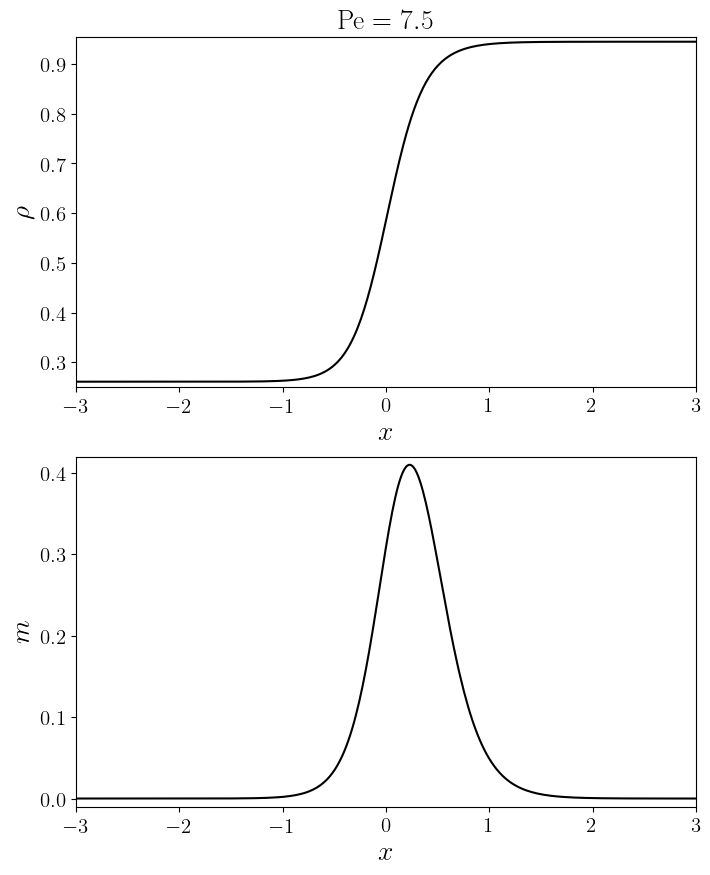

In [173]:
using PyPlot
#plot figure
PyPlot.close("all")
fig, axs = plt.subplots(2, 1, figsize=(8,10))
xlabels = [L"\rho", L"m"]
for i in 1:2
    ax = axs[i]
    ax.plot(sol.t[:].-sol.t[infec_pt], sol[i,:], color = "black")
    axlim = [ -t_lim, t_lim, minimum(sol[i,:])-0.01, maximum(sol[i,:])+0.01]
    ax.xaxis.set_tick_params(labelsize=15)
    ax.xaxis.tick_bottom()
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axis(axlim)
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    ax.set_ylabel(xlabels[i],fontsize=20)
    ax.set_xlabel(L"x",fontsize=20)
end
fig_title = latexstring("\$ \\mathrm{Pe} = $(Pe) \$")
axs[1].set_title(fig_title,fontsize=20)
display(fig)

Running solution pathfinder: 


In [190]:
Lx,Nx,ϕa,ϕp,v0 = 25.0, 1600, 0.5762103165847051,0.08348221847463011, 7.5
# Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.562033779065575,0.0, 7.5
f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");
steps = 20
ϕa_start, ϕp_start = copy(ϕa), copy(ϕp)
# ϕa_end, ϕp_end = 0.4923593417152868, 0.2120026039537824
ϕa_end, ϕp_end = 0.5628841851148594, 0.19210167920225363
# ϕa_end, ϕp_end = 0.5,0.00

for (ϕa, ϕp) in zip(collect(ϕa_start:( (ϕa_end-ϕa_start )/steps):ϕa_end), collect(ϕp_start:( (ϕp_end-ϕp_start )/steps):ϕp_end)) 
    global f,u,c,Lx,Nx,v0
    f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 10)
    param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0)
    err, erri, avmag, cep = check_u_full(u,ps);
    println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)")
    if err>1e-5
        break
    end
    # println(ϕa, ϕp)
end

for ϕa in collect(ϕa_start:( (ϕa_end-ϕa_start )/steps):ϕa_end)
    global f,u,c,Lx,Nx,v0, ϕp
    Lx,Nx,_,_,v0 = 25.0, 800, 0.5762103165847051,0.08348221847463011, 7.5
    f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 10)
    param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0)
    err, erri, avmag, cep = check_u_full(u,ps);
    println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)")
    if err>1e-5
        break
    end
    # println(ϕa, ϕp)
end

ϕa,ϕp=(0.562033779065575,0.0): cep =-0.003016536024297772, err=1.6985668427338396e-10,1203


ArgumentError: ArgumentError: range step cannot be zero

Upscaling Solution:

In [79]:
# lengthen
function lengthen_f(f,param, LLx, NNx)
    @unpack Nx, Lx, Δx = param
    ΔΔx = Lx/NNx
    function fx(x,k)
        i::Int64 = x÷Δx
        j = i+1
        if i == 0
            return ( (Δx*(i+1)- x)*f[Nx,k] + (x-Δx*i)*f[j,k] )/(Δx)
        end
        if i == Nx
            j = 1
        end
        return ( (Δx*(i+1)- x)*f[i,k] + (x-Δx*i)*f[j,k] )/(Δx)
    end
    g = zeros(NNx,3)
    for i in 1:3
        g[:,i] = fx.(ΔΔx:ΔΔx:Lx,i)
    end

    Δx = LLx/NNx
    Lx = LLx
    Nx = NNx
    @pack! param = Nx, Lx, Δx

    return param, g
end

lengthen_f (generic function with 1 method)

In [90]:
# lengthen
function lengthen_f(f,param, LLx, NNx)
    @unpack Nx, Lx, Δx = param
    ΔΔx = Lx/NNx
    function fx(x,k)
        i::Int64 = x÷Δx
        j = i+1
        if i == 0
            return ( (Δx*(i+1)- x)*f[Nx,k] + (x-Δx*i)*f[j,k] )/(Δx)
        end
        if i == Nx
            j = 1
        end
        return ( (Δx*(i+1)- x)*f[i,k] + (x-Δx*i)*f[j,k] )/(Δx)
    end
    g = zeros(NNx,3)
    for i in 1:3
        g[:,i] = fx.(ΔΔx:ΔΔx:Lx,i)
    end

    Δx = LLx/NNx
    Lx = LLx
    Nx = NNx
    @pack! param = Nx, Lx, Δx

    return param, g
end

# Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.4923593417152868, 0.2156, 7.5
# Lx,Nx,ϕa,ϕp,v0 = 25.0, 800, 0.5,0.0, 7.5
# Lx,Nx,ϕa,ϕp,v0 = 25.0, 1600, 0.4923593417152868,0.2120026039537824, 7.5
# Lx,Nx,ϕa,ϕp,v0 = 25.0, 1600, 0.5628841851148594,0.19210167920225363, 7.5
Lx,Nx,ϕa,ϕp,v0 = 25.0, 3200, 0.564216798261844, 0.18123973312949127, 7.5;


f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

Lx,Nx,ϕa,ϕp,v0 = Lx,2*Nx,ϕa,ϕp,v0 
param, f = lengthen_f(f,param, Lx, Nx)
u = get_u(f,c)
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 10);

f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");


ϕa,ϕp=(0.564216798261844,0.18123973312949127): cep =-0.005474724563176791, err=2.6948767523071737e-10,3809
ϕa,ϕp=(0.564216798261844,0.18123973312949127): cep =-0.005474724563176791, err=0.0026757601050209634,7579


([0.20744966977947327 0.37504414175438966 0.16543475135169194; 0.20831936836001924 0.37830356192866527 0.16378879412744596; … ; 0.20578031498535138 0.36851183308207475 0.1687047037085181; 0.20660343939021641 0.3717794352179177 0.16707365678320119], [0.7479285628855549; 0.7504117244161305; … ; 0.16517599582770123; -0.002820002620436848;;], -0.002820002620436848)

In [93]:
Lx,Nx,ϕa,ϕp,v0 = 25.0, 3200, 0.564216798261844, 0.18123973312949127, 7.5
f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

ϕa,ϕp=(0.564216798261844,0.18123973312949127): cep =-0.002820002620436848, err=5.297672023285571e-14,183


In [ ]:
# lengthen 
# Lx,Nx,ϕa,ϕp,v0 = 25.0, 3200, 0.4923593417152868,0.2120026039537824, 7.5
# Lx,Nx,ϕa,ϕp,v0 = 25.0, 3200, 0.5628841851148594,0.19210167920225363, 7.5
f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");
old_Lx = copy(Lx);

for Lx in 30.0:10.0:100.0
    param, f = lengthen_f(f,param, Lx, Nx)
    u = get_u(f,old_Lx*c/Lx)
    f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 10)
    param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
    err, erri, avmag, cep = check_u_full(u,ps);
    println("Lx=$(Lx), ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");
    if err > 1e-6
        break
    end
    old_Lx = copy(Lx)
end

In [29]:
# lengthen
function lengthen_f(f,param, LLx, NNx)
    @unpack Nx, Lx, Δx = param
    ΔΔx = Lx/NNx
    function fx(x,k)
        i::Int64 = x÷Δx
        j = i+1
        if i == 0
            return ( (Δx*(i+1)- x)*f[Nx,k] + (x-Δx*i)*f[j,k] )/(Δx)
        end
        if i == Nx
            j = 1
        end
        return ( (Δx*(i+1)- x)*f[i,k] + (x-Δx*i)*f[j,k] )/(Δx)
    end
    g = zeros(NNx,3)
    for i in 1:3
        g[:,i] = fx.(ΔΔx:ΔΔx:Lx,i)
    end

    Δx = LLx/NNx
    Lx = LLx
    Nx = NNx
    @pack! param = Nx, Lx, Δx

    return param, g
end
# densify 
# Lx,Nx,ϕa,ϕp,v0 = 25.0, 1600, 0.4923593417152868,0.2120026039537824, 7.5;
# Lx,Nx,ϕa,ϕp,v0 = 25.0, 1600, 0.5628841851148594,0.19210167920225363, 7.5
# Lx,Nx,ϕa,ϕp,v0 = 100.0, 3200, 0.564216798261844,0.18123973312949127, 7.5;
Lx,Nx,ϕa,ϕp,v0 = 25.0, 1600, 0.5931, 0.18123973312949127, 7.5;

f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

Lx,Nx,ϕa,ϕp,v0 = Lx,2*Nx,ϕa,ϕp,v0 ;
param, f = lengthen_f(f,param, Lx, Nx);
u = get_u(f,c);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 10);
u = get_u(f,c);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");

In [294]:
# lengthen 
Lx,Nx,ϕa,ϕp,v0 = 25.0, 1600, 0.5,0.0, 7.5;
f,u,c = load_full(Lx,Nx,ϕa,ϕp,v0);
param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
err, erri, avmag, cep = check_u_full(u,ps);
println("ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");
old_Lx = copy(Lx);

# for Lx in 60.0:10.0:100.0
#     param, f = lengthen_f(f,param, Lx, Nx)
#     u = get_u(f,old_Lx*c/Lx)
#     f,u,c = solve_full(Lx,Nx,ϕa,ϕp,v0,u; tol = 1e-8, maxiters = 10)
#     param, ps = get_param_full(Lx,Nx,ϕa,ϕp,v0);
#     err, erri, avmag, cep = check_u_full(u,ps);
#     println("Lx=$(Lx), ϕa,ϕp=($(ϕa),$(ϕp)): cep =$(cep), err=$(err),$(erri)");
#     if err > 1e-6
#         break
#     end
#     old_Lx = copy(Lx) 
# end

ϕa,ϕp=(0.5,0.0): cep =-0.0013819804037916432, err=2.2018758543893013e-9,1680


25.0